# Neurosymbolic Software Tutorial - ECG Dataset

<a target="_blank" href="https://colab.research.google.com/github/kavigupta/neurosym-lib/blob/main/tutorial/ecg_exercise.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executible code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side.
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, and opening this notebook from within Google Drive.

## Notebook

In this notebook, you will construct a DSL to analyze ECG data.

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import neurosym as ns
from neurosym.examples import near

pl = ns.import_pytorch_lightning()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

We then load and plot some bouncing ball trajectories. Note that these trajectories are represented as a list `[x, y, vx, vy]`

In [31]:
def load_dataset_npz(features_pth, label_pth):
    assert os.path.exists(features_pth), f"{features_pth} does not exist."
    assert os.path.exists(label_pth), f"{label_pth} does not exist."
    X = np.load(features_pth)
    y = np.load(label_pth)
    return X, y


def filter_multilabel(split):
    x_fname = f"ecg_exercise/x_{split}.npy"
    y_fname = f"ecg_exercise/y_{split}.npy"
    X = np.load(x_fname)
    y = np.load(y_fname)

    mask = y.sum(-1) == 1

    # filter
    X = X[mask]
    y = y[mask]

    # normalize each column of X to [0, 1]
    X = (X - X.min(0)) / (X.max(0) - X.min(0))

    # save as filtered
    np.save(x_fname.replace(f"{split}", f"{split}_filtered"), X)
    np.save(y_fname.replace(f"{split}", f"{split}_filtered"), y)


filter_multilabel("train")
filter_multilabel("test")

In [32]:
dataset_factory = lambda train_seed: ns.DatasetWrapper(
    ns.DatasetFromNpy(
        f"ecg_exercise/x_train_filtered.npy",
        f"ecg_exercise/y_train_filtered.npy",
        train_seed,
    ),
    ns.DatasetFromNpy(
        f"ecg_exercise/x_test_filtered.npy",
        f"ecg_exercise/y_test_filtered.npy",
        None,
    ),
    batch_size=200,
)
datamodule = dataset_factory(42)

In [33]:
def plot_trajectory(trajectory, color):
    # TODO: What is a good way to visualize the trajectory?
    pass

In [34]:
for i in range(3):
    plot_trajectory(datamodule.train.inputs[:], f"C{i}")

## Exercise: DSL

Fill in the `bounce_dsl` to parameterize the space of functions that could represent the trajectories of bouncing balls.

In [36]:
datamodule.train.get_io_dims()

(144, 2)

In [87]:
def subset_selector_all_feat(x, channel, typ):
    x = x.reshape(-1, 12, 6, 2)
    typ_idx = torch.full(
        size=(x.shape[0],), fill_value=(0 if typ == "interval" else 1), device=x.device
    )
    channel_mask = channel(x.reshape(-1, 144))  # [B, 12]
    masked_x = (x * channel_mask[..., None, None]).sum(1)
    return masked_x[torch.arange(x.shape[0]), :, typ_idx]

def guard_callables(fn, **kwargs):
    is_callable = [callable(kwargs[k]) for k in kwargs]
    if any(is_callable):
        return lambda z: fn(
            **{
                k: (kwargs[k](z) if is_callable[i] else kwargs[k])
                for i, k in enumerate(kwargs)
            }
        )
    else:
        return fn(**kwargs)

def filter_constants(x):
    match x:
        case ns.ArrowType(a, b):
            return filter_constants(a) and filter_constants(b)
        case ns.AtomicType(a):
            return a not in ["channel", "feature"]
        case _:
            return True

def filter_same_type(x):
    raise NotImplementedError

def ecg_dsl():
    L = 144
    O = 2
    F = 6
    dslf = ns.DSLFactory(L=L, O=O, F=F, max_overall_depth=10)
    dslf.typedef("fInp", "{f, $L}")
    dslf.typedef("fOut", "{f, $O}")
    dslf.typedef("fFeat", "{f, $F}")

    for i in range(12):
        dslf.concrete(
            f"channel_{i}",
            "() -> () -> channel",
            # onehot vector where the ith element is 1
            # lambda: lambda x: torch.full(
            #     tuple(x.shape[:-1] + (1,)), i, device=x.device
            # ),
            lambda: lambda x: torch.nn.functional.one_hot(
                torch.full(tuple(x.shape[:-1]), i, device=x.device, dtype=torch.long),
                num_classes=12,
            ),
        )

    dslf.concrete(
        "select_interval",
        "(() -> channel) -> ($fInp) -> $fFeat",
        lambda ch: lambda x: subset_selector_all_feat(x, ch, "interval"),
    )

    dslf.concrete(
        "select_amplitude",
        "(() -> channel) -> ($fInp) -> $fFeat",
        lambda ch: lambda x: subset_selector_all_feat(x, ch, "amplitude"),
    )

    dslf.filtered_type_variable("num", lambda x: filter_constants(x))
    dslf.filtered_type_variable("num", lambda x: filter_same_type(x))
    dslf.concrete(
        "add",
        "(%num, %num) -> %num",
        lambda x, y: guard_callables(fn=lambda x, y: x + y, x=x, y=y),
    )
    dslf.concrete(
        "mul",
        "(%num, %num) -> %num",
        lambda x, y: guard_callables(fn=lambda x, y: x * y, x=x, y=y),
    )

    dslf.parameterized(
        "linear",
        "(($fInp) -> $fFeat) -> $fInp -> {f, 1}",
        lambda f, lin: lambda x: lin(f(x)),
        dict(lin=lambda: nn.Linear(F, 1)),
    )

    dslf.parameterized(
        "output",
        "(($fInp) -> $fFeat) -> $fInp -> $fOut",
        lambda f, lin: lambda x: lin(f(x)),
        dict(lin=lambda: nn.Linear(F, O)),
    )

    # dslf.concrete("ite_ab", "(#a -> f, #a -> #b, #a -> #b) -> #a -> #b", near.operations.ite_torch)
    # dslf.concrete("ite_aa", "(#a -> f, #a -> #a, #a -> #a) -> #a -> #a", near.operations.ite_torch)
    # dslf.concrete(
    #     "map", "(#a -> #b) -> [#a] -> [#b]", lambda f: lambda x: near.operations.map_torch(f, x)
    # )
    dslf.prune_to("($fInp) -> $fOut")
    return dslf.finalize()
dsl = ecg_dsl()

NotImplementedError: 

### DSL Printout

See your DSL printed below, and ensure it is what you would expect

In [8]:
print(dsl.render())

            ite :: (#a -> f, #a -> #a, #a -> #a) -> #a -> #a
            map :: (#a -> #b) -> [#a] -> [#b]
linear_bool[lin] :: () -> {f, 4} -> f
    linear[lin] :: () -> {f, 4} -> {f, 4}


### Setting up Neural DSL

In [9]:
input_dim, output_dim = 4, 4
t = ns.TypeDefiner(L=input_dim, O=output_dim)
t.typedef("fL", "{f, $L}")
neural_dsl = near.NeuralDSL.from_dsl(
    dsl=dsl,
    modules={
        **near.create_modules(
            "mlp",
            [t("($fL) -> $fL")],
            near.mlp_factory(hidden_size=10),
        ),
        **near.create_modules(
            "rnn_seq2seq",
            [t("([$fL]) -> [$fL]")],
            near.rnn_factory_seq2seq(hidden_size=10),
        ),
    },
)
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)


trainer_cfg = near.NEARTrainerConfig(
    lr=5e-3,
    max_seq_len=300,
    n_epochs=100,
    num_labels=output_dim,
    train_steps=len(datamodule.train),
    loss_callback=torch.nn.functional.mse_loss,
    scheduler="cosine",
    optimizer=torch.optim.Adam,
)

validation_cost = near.ValidationCost(
    neural_dsl=neural_dsl,
    trainer_cfg=trainer_cfg,
    datamodule=datamodule,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5)
    ],
    enable_progress_bar=False,
    enable_model_summary=False,
    progress_by_epoch=True,
)

g = near.near_graph(
    neural_dsl,
    ns.parse_type(
        s="([{f, $L}]) -> [{f, $O}]", env=ns.TypeDefiner(L=input_dim, O=output_dim)
    ),
    is_goal=neural_dsl.program_has_no_holes,
)


### Run NEAR

In [10]:
iterator = ns.search.bounded_astar(g, validation_cost, max_depth=16)
best_program_nodes = []
# Let's collect the top four programs
while len(best_program_nodes) <= 3:
    try:
        node = next(iterator)
        cost = validation_cost(node)
        best_program_nodes.append((node, cost))
        print("Got another program")
    except StopIteration:
        print("No more programs found.")
        break

Training ??::<[{f, 4}] -> [{f, 4}]>


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (ite ??::<[{f, 4}] -> f> ??::<[{f, 4}] -> [{f, 4}]> ??::<[{f, 4}] -> [{f, 4}]>)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map ??::<{f, 4} -> {f, 4}>)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (__neural_dsl_internal_rnn_seq2seq_1)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (linear))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (__neural_dsl_internal_mlp_1))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (linear))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Got another program
Training (map (ite (linear_bool) ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Got another program
Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (linear) ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (linear) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1)) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1)) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1)) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1)) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1)) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1)) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear)) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear)) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear)) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Got another program
Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite (linear_bool) ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite (linear_bool) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite (linear_bool) (linear) ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite (linear_bool) (__neural_dsl_internal_mlp_1) ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite (linear_bool) (linear) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite (linear_bool) (linear) (linear))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite (linear_bool) ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite (linear_bool) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite (linear_bool) (__neural_dsl_internal_mlp_1) ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) (linear))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) (linear))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Got another program


### Top 3 Programs

The code below assumes you found some top 3 programs and stored them in the best_program_nodes variable.

In [11]:
best_program_nodes = sorted(best_program_nodes, key=lambda x: x[1])
for i, (node, cost) in enumerate(best_program_nodes):
    print(
        "({i}) Cost: {cost:.4f}, {program}".format(
            i=i, program=ns.render_s_expression(node.program), cost=cost
        )
    )

(0) Cost: 7.1469, (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) (linear))))
(1) Cost: 8.9802, (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) (linear)))
(2) Cost: 10.8157, (map (ite (linear_bool) (linear) (linear)))
(3) Cost: 16.5965, (map (linear))


The function below is set up to further fine tune the program, test it, and return a set of values produced by it.

In [12]:
def testProgram(best_program_node):
    module = near.TorchProgramModule(
        dsl=neural_dsl, program=best_program_node[0].program
    )
    pl_model = near.NEARTrainer(module, config=trainer_cfg)
    trainer = pl.Trainer(
        max_epochs=4000,
        devices="auto",
        accelerator="cpu",
        enable_checkpointing=False,
        logger=False,
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5)
        ],
        enable_progress_bar=False,
    )

    trainer.fit(pl_model, datamodule.train_dataloader(), datamodule.val_dataloader())
    T = 100
    path = np.zeros((T, 4))
    X = torch.tensor(
        np.array([0.21413583, 4.4062634, 3.4344807, 0.12440437]), dtype=torch.float32
    )
    for t in range(T):
        path[t, :] = X.detach().numpy()
        Y = module(X.unsqueeze(0)).squeeze(0)
        X = Y
    return path

In [13]:
# We generate trajectories for the top 2 programs.
trajectory = testProgram(best_program_nodes[0])
trajectoryb = testProgram(best_program_nodes[1])


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 70    
---------------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)

  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 70    
---------------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


## Plotting Trajectories

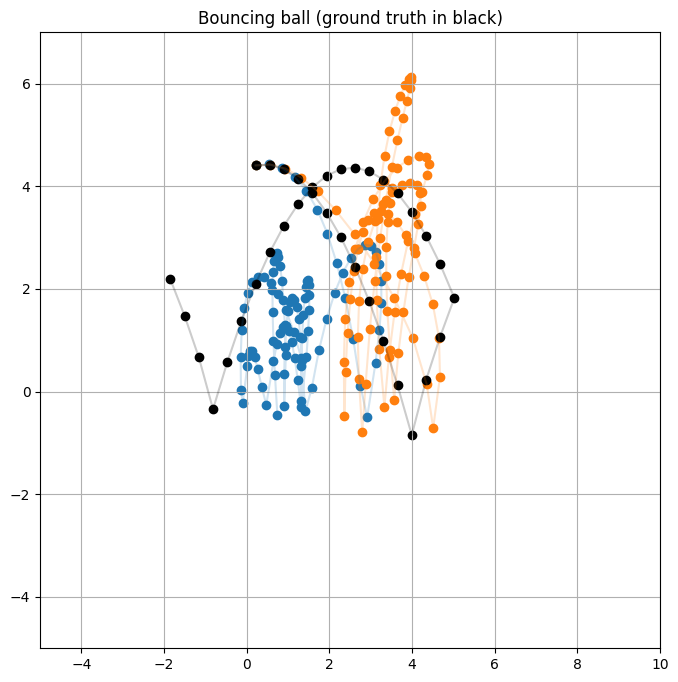

In [14]:
plt.figure(figsize=(8, 8))

plot_trajectory(trajectory, "C0")
plot_trajectory(trajectoryb, "C1")
plot_trajectory(datamodule.train.inputs[0], "black")

plt.title("Bouncing ball (ground truth in black)")
plt.show()
